# # Generating Fits with linear parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
# Initial parameters
from unittest import result


base_params = {
    'I0': 5.0,
    'gamma': 1.2,
    'r_g': 1,
    'sigma': 0.2,
    'f': 0.6
}

number_of_profiles = 5

params = []
results = []

In [3]:
# Random generator for parameters with normal distribution
params_sigma = {
    'I0': 0.5,
    'gamma': 0.3,
    'r_g': 0.2,
    'sigma': 0.1,
    'f': 0.1
}


def random_params(base_params):
    return {
        'I0': np.random.normal(base_params['I0'], params_sigma['I0']),
        'gamma': np.random.normal(base_params['gamma'], params_sigma['gamma']),
        'r_g': np.random.normal(base_params['r_g'], params_sigma['r_g']),
        'sigma': np.random.normal(base_params['sigma'], params_sigma['sigma']),
        'f': np.random.normal(base_params['f'], params_sigma['f'])
    }

In [4]:
# Linear generator for parameters
param_steps = {
    'I0':  0,
    'gamma': 0,
    'r_g': 0.3,
    'sigma': 0,
    'f': 0
}


def linear_params(base_params, step, index):
    return {
        'I0': base_params['I0'] + step['I0'] * index,
        'gamma': base_params['gamma'] + step['gamma'] * index,
        'r_g': base_params['r_g'] + step['r_g'] * index,
        'sigma': base_params['sigma'] + step['sigma'] * index,
        'f': base_params['f'] + step['f'] * index
    }

In [5]:
params = [linear_params(base_params, param_steps, i) for i in range(number_of_profiles)]

### Synthetic Profile

In [6]:
# Model definition
r = np.linspace(0.1, 3, 300)


# The model function
def model(r, I0, gamma, r_g, sigma, f):
    c = 0.3
    R_cutL = 0.1  # Fixed
    R_cutR = 3.0  # Fixed

    r_sinc = c * (np.pi * ((r - r_g) / sigma))**2

    powerlaw = I0 * ((r / r_g)**(-gamma))
    sinc = np.sin(r_sinc) / r_sinc
    gauss = np.exp((-(r - r_g)**4) / (2 * sigma**4))
    L_cut_factor = (r >= R_cutL).astype(float)
    R_cut_factor = (r <= R_cutR).astype(float)
    # NO_SINC_MODEL
    gap_factor = (1 - f * (gauss))

    return powerlaw * gap_factor * L_cut_factor * R_cut_factor


# Image generation from the profile
def generate_image_from_profile(radius, intensity, image_size=256):
    # Ensure radius and intensity are numpy arrays
    radius = np.asarray(radius)
    intensity = np.asarray(intensity)

    # Check if radius and intensity have the same length
    if radius.shape != intensity.shape:
        raise ValueError("Radius and intensity must have the same shape.")

    y, x = np.indices((image_size, image_size))
    center = (image_size - 1) / 2
    r_img = np.sqrt((x - center)**2 + (y - center)**2)

    # Rescale so that max pixel radius = max profile radius
    r_img = r_img / r_img.max() * radius.max()

    # Interpolate profile onto the pixel grid
    image = np.interp(r_img, radius, intensity, left=0, right=0)
    return image

In [7]:
# Generate profile, image, and save as FITS
for i, param in enumerate(params):

    # Profile generation
    profile = model(r, param.get("I0"), param.get("gamma"), param.get("r_g"), param.get("sigma"), param.get("f"))

    # Create 2D
    image = generate_image_from_profile(r, profile, image_size=128)

    # Save as a FITS file
    hdu = fits.PrimaryHDU(image)
    hdu.writeto(f'Generated/synthetic_disk_{i}.fits', overwrite=True)
    fits_filename = f'Generated/synthetic_disk_{i}.fits'

    # Store results
    results.append({
        'fits_filename': fits_filename,
        'profile': profile,
        'params': param,
        'image': image,
        'hdu': hdu
    })

Generated/synthetic_disk_0.fits
Parameters: I0=5.00, gamma=1.20, r_g=1.00, sigma=0.20, f=0.60


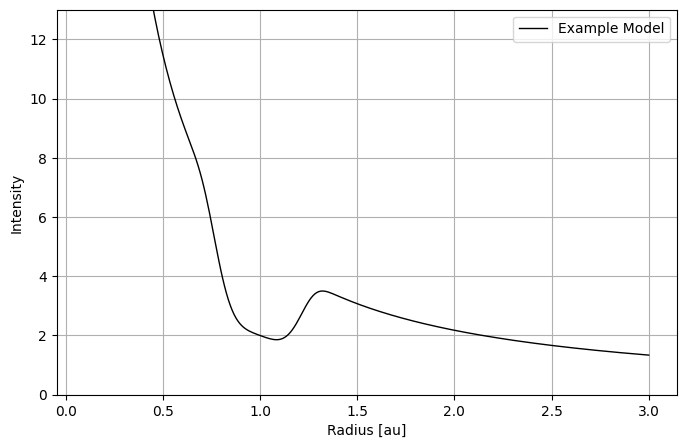

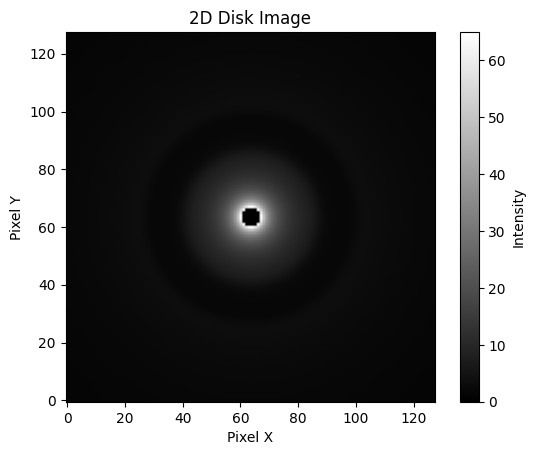

Generated/synthetic_disk_1.fits
Parameters: I0=5.00, gamma=1.20, r_g=1.30, sigma=0.20, f=0.60


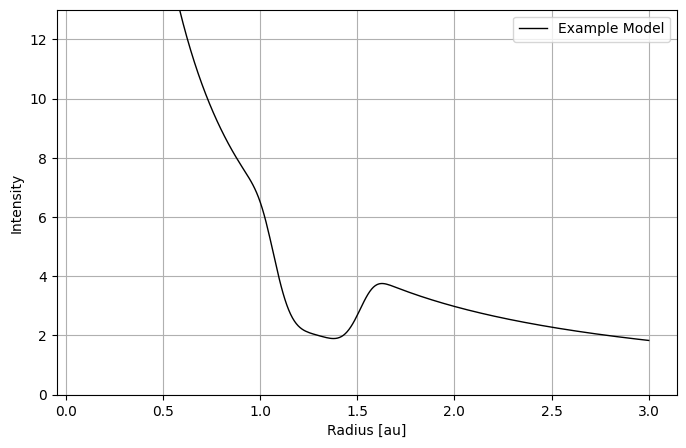

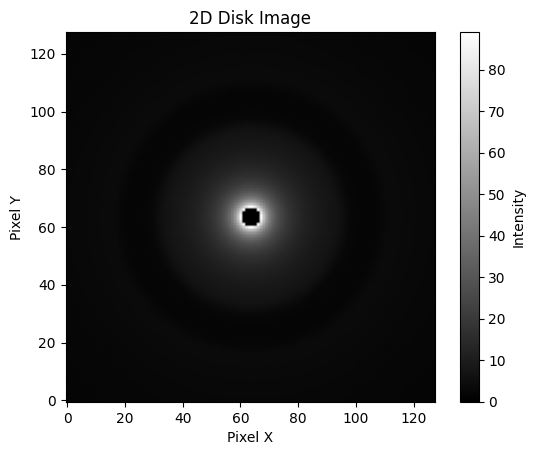

Generated/synthetic_disk_2.fits
Parameters: I0=5.00, gamma=1.20, r_g=1.60, sigma=0.20, f=0.60


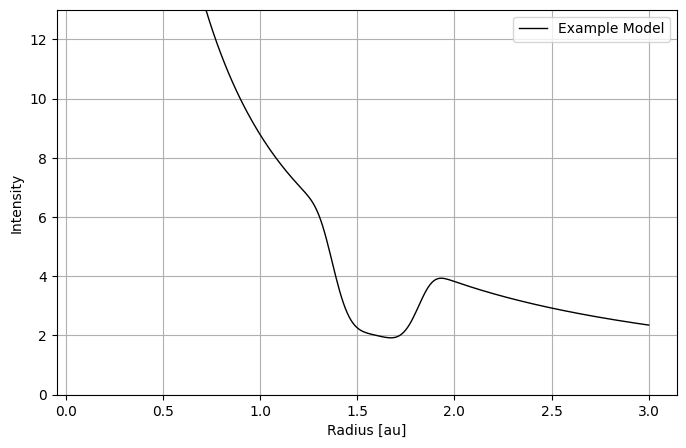

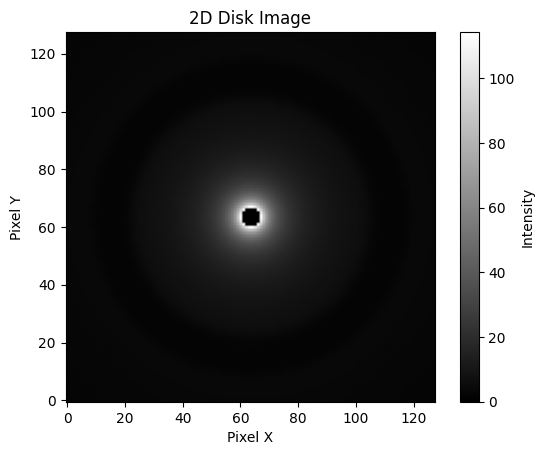

Generated/synthetic_disk_3.fits
Parameters: I0=5.00, gamma=1.20, r_g=1.90, sigma=0.20, f=0.60


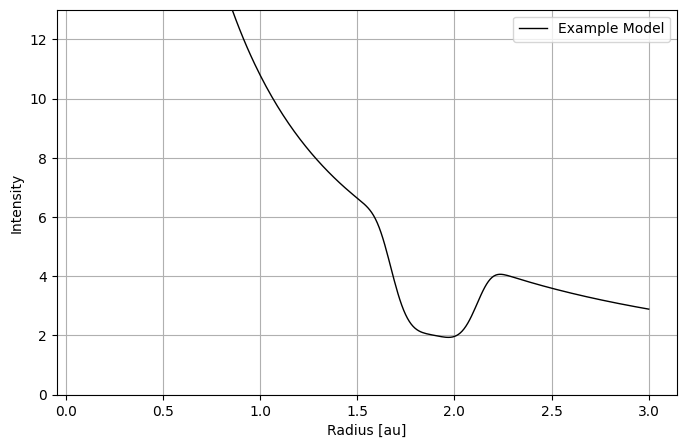

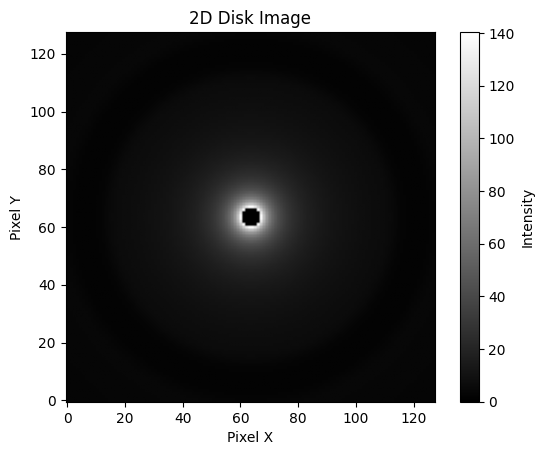

Generated/synthetic_disk_4.fits
Parameters: I0=5.00, gamma=1.20, r_g=2.20, sigma=0.20, f=0.60


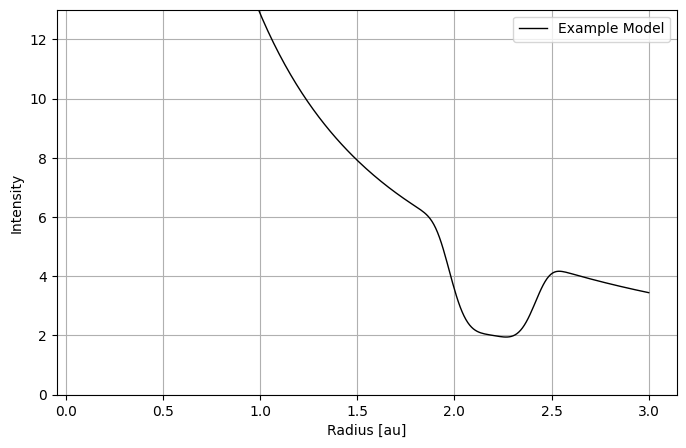

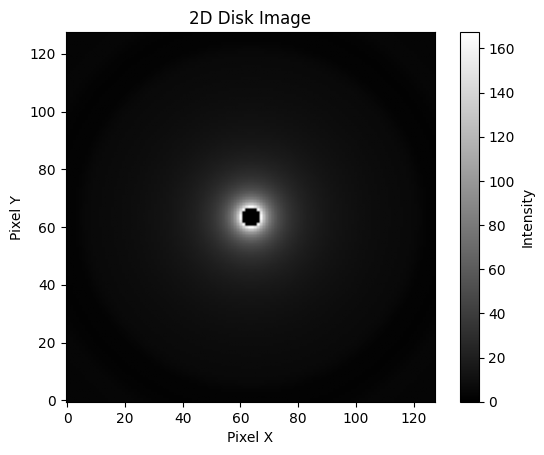

In [8]:
for result in results:

    # Print FITS filename
    print(result.get('fits_filename'))

    # Print parameters
    param = result.get('params')
    print(
        f"Parameters: "
        f"I0={param.get('I0'):.2f}, "
        f"gamma={param.get('gamma'):.2f}, "
        f"r_g={param.get('r_g'):.2f}, "
        f"sigma={param.get('sigma'):.2f}, "
        f"f={param.get('f'):.2f}"
    )

    # Graph
    plt.figure(figsize=(8, 5))
    plt.plot(r, result.get('profile'), label="Example Model", color="black", linestyle="-", linewidth=1)
    plt.xlabel("Radius [au]")
    plt.ylabel("Intensity")
    plt.ylim(0, 2 * np.max(model(r, 1.0, 1.0, 0.65, 0.1, 0.5)))
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2D Image
    plt.imshow(result.get('image'), origin='lower', cmap='grey')
    plt.colorbar(label='Intensity')
    plt.title('2D Disk Image')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')
    plt.show()